## Setup The Pre-trainined Model

You will need to prepare the pre-trained model and configure the layers that you'll need

For this example:
1. Set the input shape to fit your application (150 x 150 x 3)

2. Pick and freeze the convolution layers to take advantage of the features it has learned already

3. Add dense layers which you will train 

First Prepare the input model by fetching the pre-trained weights of the InceptionV3 model and remove the fully connected layer at the end. 

You'll also specifiy the input shape that your model will accept

Finally, freeze the weights of these layers since they've already been trained

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

#set the weights file you downloaded into a variable
local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

#Initialize the base model
#Set the input shape and remove the dense layers
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False, 
                                weights = None)

#Load the pre-trained weights you downloaded
pre_trained_model.load_weights(local_weights_file)

#Freeze the weights of the layers
for layer in pre_trained_model.layers:
  layer.trainable = False

You can see the summary of the model below and that it is a very deep network (many hidden layers)

You will use up to layer `mixed_7` in the network since the later layers from the original model might be too specialized in what it has learned 

In [ ]:
pre_trained_model.summary()

In [4]:
#Choose mixed_7 as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_ouput = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Add dense layers for your classifier

Next add dense layers to the model

These will be the layers that you will train and is tasked with recognizing cats and dogs

You will also add a Dropout layer to regularize the output and avoid overfitting

In [6]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

#Flatten the output layer to 1 dimension 
x = layers.Flatten()(last_ouput)

#Add a fully connected layer with 1,024 hidden units and relu activation 
x = layers.Dense(1024, activation='relu')(x)

#Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

#Add a final sigmoid layer for classification 
x = layers.Dense(1, activation='sigmoid')(x)

#Append the dense network to the base model 
model = Model(pre_trained_model.input, x)

#Print the model summary so you can see your model connected at the end 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                              

In [12]:
#Set the training parameters 
model.compile(optimizer = RMSprop(learning_rate = 1e-4),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## Prepare the dataset 

Pretty much the same code used in the augmentation lab

In [13]:
import os 
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [14]:
#Define the example directories and files 
base_dir = './cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

#Directory with training cat pictures 
train_cats_dir = os.path.join(train_dir, 'cats')

#Directory with training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')

#Directory with validation cat pictures 
test_cats_dir = os.path.join(validation_dir, 'cats')

#Directory with validation dog pictures 
test_dogs_dir = os.path.join(validation_dir, 'dogs')



#Add data augmentation parameters to ImageDataGenerator 
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#Note that the validation data (test_datagen) should NOT be augmented
test_datagen = ImageDataGenerator(rescale = 1/255)

#Flow training images in batches of 20 using train_datagen generator 
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

#Flow validation images in batches of 20 using test_datagen
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size = 20,
                                                        class_mode = 'binary',
                                                        target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
#Train the model 
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_steps = 50,
    verbose = 1
)

Epoch 1/20
100/100 [==============================] - 144s 1s/step - loss: 0.3274 - accuracy: 0.8715 - val_loss: 0.1752 - val_accuracy: 0.9390
Epoch 2/20
100/100 [==============================] - 139s 1s/step - loss: 0.2355 - accuracy: 0.9155 - val_loss: 0.1848 - val_accuracy: 0.9360
Epoch 3/20
100/100 [==============================] - 138s 1s/step - loss: 0.2015 - accuracy: 0.9170 - val_loss: 0.1542 - val_accuracy: 0.9480
Epoch 4/20
100/100 [==============================] - 138s 1s/step - loss: 0.1879 - accuracy: 0.9310 - val_loss: 0.1104 - val_accuracy: 0.9610
Epoch 5/20
100/100 [==============================] - 139s 1s/step - loss: 0.1935 - accuracy: 0.9340 - val_loss: 0.1248 - val_accuracy: 0.9550
Epoch 6/20
100/100 [==============================] - 138s 1s/step - loss: 0.1820 - accuracy: 0.9345 - val_loss: 0.1141 - val_accuracy: 0.9650
Epoch 7/20
100/100 [==============================] - 138s 1s/step - loss: 0.1727 - accuracy: 0.9395 - val_loss: 0.2350 - val_accuracy: 0.9270

You can see that the model is no longer overfitting and that both the training and validation accuracies are very high

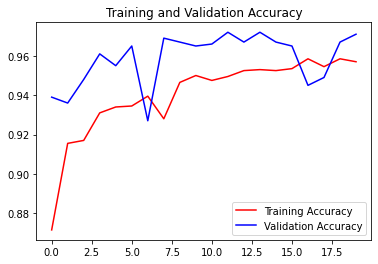

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()